In [1]:
import pickle
from collections import Counter
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from DataObjs import Corpus, success_transform, confidence_transform

In [3]:
with open('Data/data_regression.p') as handle:
    raw_data = pickle.load(handle)
    
# length, lex, form -> all, p, e
# data point = (sccss_str, conf_str, ([], [], []), ([], [], []), ([], [], []))     
    
# nonoise
data_en = Corpus(raw_data[1], succs_map=success_transform, conf_map=confidence_transform)
# FTT
data_de = Corpus(raw_data[0], succs_map=success_transform, conf_map=confidence_transform) 

data_all = Corpus(dict(raw_data[0], **raw_data[1]), succs_map=success_transform, conf_map=confidence_transform)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


164 164
88 88


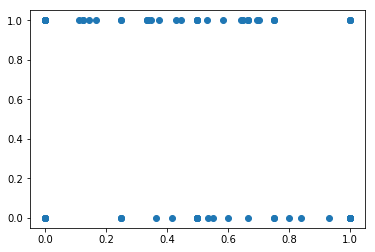

In [4]:
xs = [np.mean(mv.lex_e) for mv in data_all.moves]
ys = [1 if ((s == 1 or s == -1) and c == 4) else 0 for s, c in zip(data_all.get_succs(), data_all.get_confs())]

print len(xs), len(ys)

filtered_xs, filtered_ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if not np.isnan(x)]))

idx = np.argsort(filtered_xs)

sorted_xs = np.asarray([filtered_xs[i] for i in list(idx)])
sorted_ys = np.asarray([filtered_ys[i] for i in list(idx)])

print len(sorted_xs), len(sorted_ys)

plt.plot(sorted_xs, sorted_ys, 'o')
plt.show()

[[ 0.         -0.76397455  0.          0.         -0.33556206 -0.26266346
  -0.1789094   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]]
[ 0.66616659]
[0.66064426342959193, 0.65892856926173726, 0.6537312497957084, 0.64482374432231415, 0.63160896565463853, 0.61282076792314677, 0.58607896160581308, 0.54730437254055142, 0.49022380357229295, 0.40710147563515903]


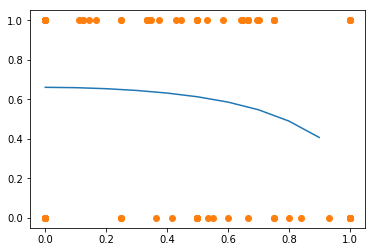

In [5]:
x_terms = [sorted_xs**i for i in range(1, 51)]
x_terms = np.asarray(x_terms).T

l = LogisticRegression(penalty='l1')
l.fit(x_terms, sorted_ys)

print l.coef_
print l.intercept_

logit = lambda x: float(1)/(1+np.e**-(l.intercept_[0] + sum(l.coef_[0][i]*x**(i+1) for i in range(50))))

plotting_range = list(np.arange(np.min(sorted_xs), np.max(sorted_xs), 0.1))
fitted = [logit(x) for x in plotting_range]
print fitted

plt.plot(plotting_range, [logit(x) for x in plotting_range])
plt.plot(sorted_xs, sorted_ys, 'o')
plt.show()